
# Intel® Geti™ SDK from Zero to Hero in 9 steps

Intel® Geti™ SDK is a Python package designed to interact with an Intel® Geti™ server via the REST API. It provides various functions for managing projects, downloading and uploading data, deploying projects for local inference, configuring projects and models, launching and monitoring training jobs, and media upload and prediction. Clone and install this repo 
https://github.com/openvinotoolkit/geti-sdk

| 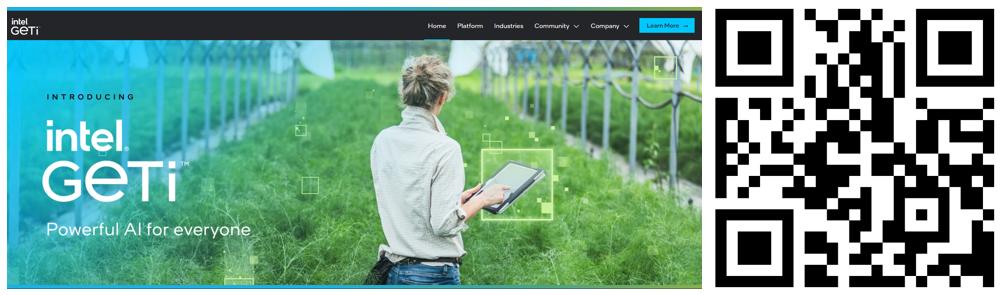 | 
|:--:| 
| *Intel® Geti™ Platform* |

|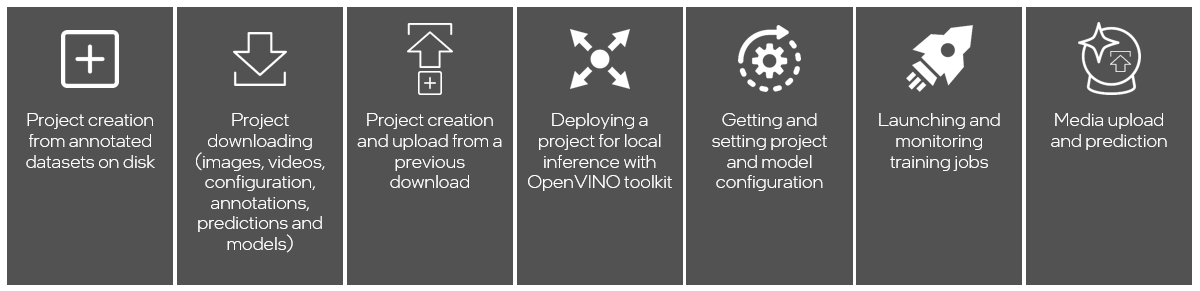 | 
|:--:| 
| *What you can do with Intel® Geti™ SDK* |

Before running this notebook, please make sure you have the Intel Geti SDK installed in your local machine. If not, please follow [these instructions](https://github.com/openvinotoolkit/geti-sdk#installation).

## Ready for the 9 steps?
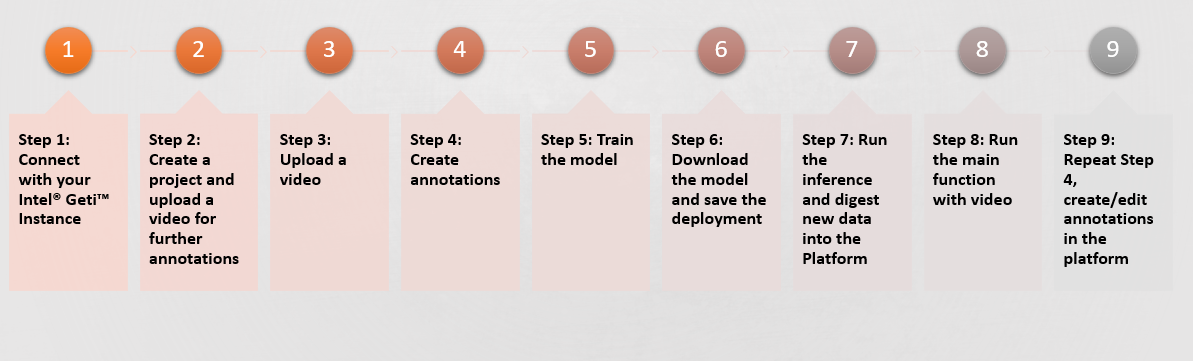

In this notebook, we will use the SDK to create a project on the Intel Geti graphics platform, upload videos, download the displays locally, and run the inference by viewing the results on this same notebook.

In [ ]:
import sys
import os.path

# Load skip_kernel_extension
sys.path.append("./utils")
%load_ext skip_kernel_extension

# Check if the .env file is present
has_env_file = os.path.isfile(os.path.join("..", ".env"))

# Step 1: Connect with your Intel® Geti™ Instance

We will connect to the platform first, using the server details from the .env file. We will also create a ProjectClient for the server. If you have doubts, please take a look of the previous work you need to do before to [connect](https://github.com/openvinotoolkit/geti-sdk#connecting-to-the-intel-geti-platform) the SDK and the platform. 

In [ ]:
%%skip not $has_env_file

# As usual we will connect to the platform first, using the server details from the .env file. We will also create a ProjectClient for the server
import os

from geti_sdk import Geti
from geti_sdk.rest_clients import ProjectClient
from geti_sdk.utils import get_server_details_from_env

geti_server_configuration = get_server_details_from_env(
    env_file_path=os.path.join("..", ".env")
)

geti = Geti(server_config=geti_server_configuration)

project_client = ProjectClient(session=geti.session, workspace_id=geti.workspace_id)

# Step 2: Create a project and upload a video for further annotations

We will create a new project from scratch and will upload a video using the SDK for further annotations into the Intel Geti Platform. We will create an object detection project for person, bike and card detection. 

| 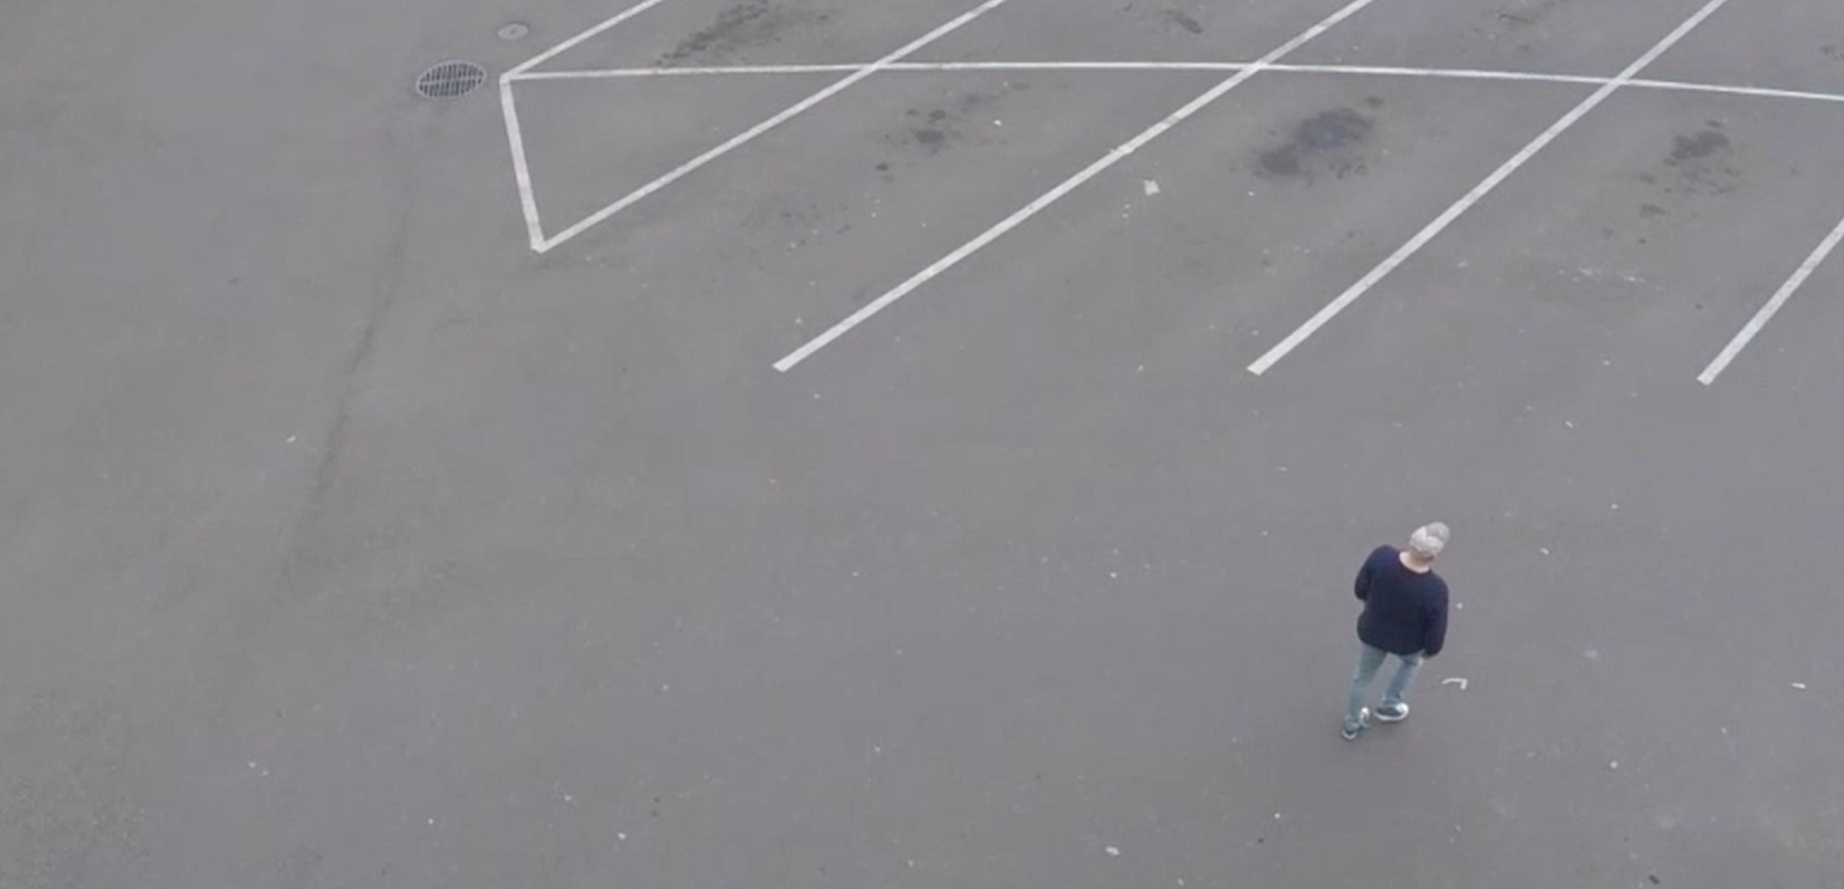 | 
|:--:| 
| *Video Frame from person-bike-car detection data* |

### Setting up the project client, video client and prediction client
For now, we will need two client objects: A `ProjectClient` to retrieve the project we want to upload to, and an `VideoClient` to be able to upload the video. We first set up the `ProjectClient`, since we will need to get the project we are interested in before we can initialize the another client.

In [ ]:
%%skip not $has_env_file

from geti_sdk.rest_clients import ProjectClient, VideoClient

project_client = ProjectClient(
    session=geti.session, workspace_id=geti.workspace_id
)  # setting up the project client

projects = (
    project_client.list_projects()
)  # listing the projects in the Intel Geti Instance

#### Project creation
For project creation we will need: 1. Project Name, 2. Project Type, and 3. Properties for each project task. See this notebook for an extensive [explanation](https://github.com/openvinotoolkit/geti-sdk/blob/main/notebooks/001_create_project.ipynb). For this use case we will create an detection task.

In [ ]:
%%skip not $has_env_file

# First set the project parameters. Feel free to experiment here!
PROJECT_NAME = "person-bike-car"  # the project we want to create
PROJECT_TYPE = "detection"  # the type of computer vision task to perform
LABELS = [["person", "car", "bike"]]  # The label names for the task

In [ ]:
%%skip not $has_env_file

# Now, use the project client to create the project
project = project_client.get_or_create_project(
    project_name=PROJECT_NAME, project_type=PROJECT_TYPE, labels=LABELS
)

# Step 3: Uploading a video

We can upload a video directly from file using the `video_client.upload_video()` method. Before uploading, we can get a list of all videos in the project, so that we can verify that the image was uploaded successfully. With the project name specified, we can retrieve the project details from the project client and use the returned `Project` object to set up an `video_client` and `prediction_client` for this project.

In [ ]:
%%skip not $has_env_file

project = project_client.get_project_by_name(PROJECT_NAME)

video_client = VideoClient(
    session=geti.session, workspace_id=geti.workspace_id, project=project
)

In [ ]:
%%skip not $has_env_file

# videos in the project before uploading
videos = video_client.get_all_videos()
print(f"Project '{project.name}' contains {len(videos)} videos.")

Now, we will upload an example video from the SDK. Of course, you can replace the `VIDEO_PATH` with a path to one of your own videos as well.

In [ ]:
%%skip not $has_env_file

from geti_sdk.demos import get_person_car_bike_video

# Get the path to the example video. This will download the video if it is not found on your disk yet
VIDEO_PATH = get_person_car_bike_video()

video = video_client.upload_video(video=VIDEO_PATH)

Let's fetch the list of videos again and see if it has changed

In [ ]:
%%skip not $has_env_file

videos = video_client.get_all_videos()
print(f"Project '{project.name}' contains {len(videos)} videos.")

# Step 4: Creating annotations
Once you upload new image or video data, you should open the Intel Geti GUI and create annotations for it. The screenshot below shows an example of the annotator page within Geti.

| 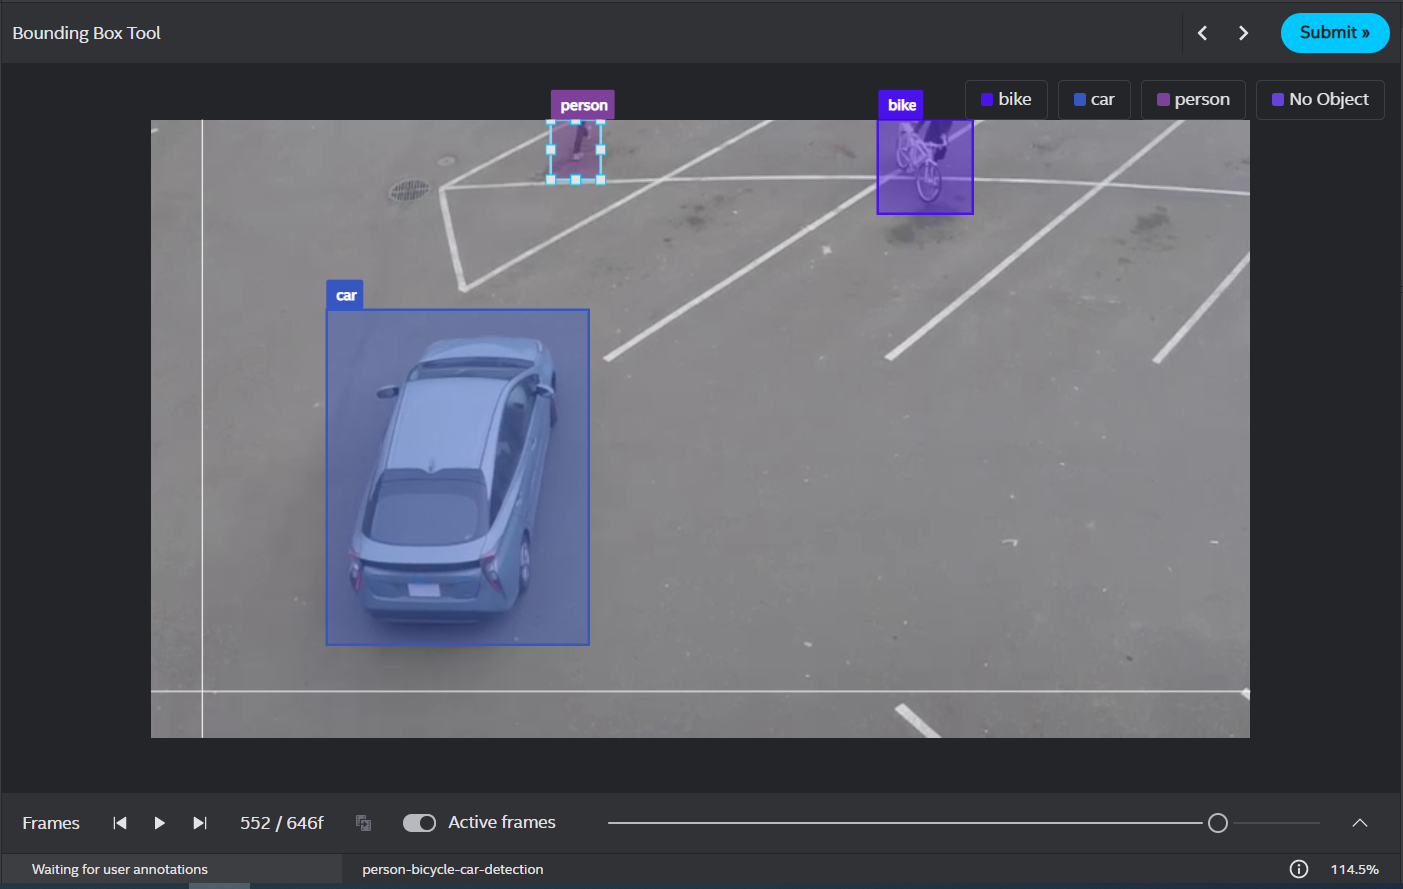 | 
|:--:| 
| *Annotations within the Intel® Geti™ Platform* |

Alternatively, if you have used the default 'person_car_bike' video that we provided, you can run the cell below to upload some pre-defined annotations for the video to the project. This saves you some time in annotating the frames.

In [ ]:
%%skip not $has_env_file

from geti_sdk.annotation_readers import GetiAnnotationReader
from geti_sdk.rest_clients import AnnotationClient

annotation_reader = GetiAnnotationReader(
    os.path.join("data", "102_from_zero_to_hero", "annotations")
)
annotation_client = AnnotationClient(
    workspace_id=geti.workspace_id,
    session=geti.session,
    project=project,
    annotation_reader=annotation_reader,
)

annotation_client.upload_annotations_for_all_media()

# Step 5: Training the model
Once sufficient annotations have been made, the project is ready for training. Due to the incremental learning mechanism within the Intel Geti platform, training will happen automatically and frequently. Whenever sufficient new annotations have been created, the platform will start a training round. 

In the next part of the notebook we will deploy the model that was trained, so that we can use it locally to generate predictions. However, before doing so we need to make sure that the project has a model trained. The cell below ensures this: It will start training and monitor the training progress if no model is available yet.

In [ ]:
%%skip not $has_env_file

from geti_sdk.demos import ensure_trained_example_project

ensure_trained_example_project(geti=geti, project_name=PROJECT_NAME);

# Step 6: Download the model and save the deployment
When the model is ready you can download the deployment and run it locally or run the inference in the platform. In this example we will download the deployment and run it locally.

Once we are sure that the project has trained models for each task, we can create the deployment in the cell below.

In [ ]:
%%skip not $has_env_file

deployment = geti.deploy_project(project_name=PROJECT_NAME)

## Saving the deployment
When we create the deployment, the model data is saved to a temporary folder. We store the deployment for offline re-use later on by saving it: This will copy the model data from the temporary folder to the path we specify. If we want to run inference locally again, we can simply reload the deployment from the saved folder, without having to connect to the platform again.

In [ ]:
%%skip not $has_env_file

PATH_TO_DEPLOYMENT_FOLDER = os.path.join("deployments", PROJECT_NAME)

deployment.save(path_to_folder=PATH_TO_DEPLOYMENT_FOLDER)

## Preparing the models for inference
Now that the `deployment` is created and the models are saved to the local disk, we can load the models into memory to prepare them for inference. There you can select the device for running the inference, in OpenVINO we have different options. You can setup `CPU`, `GPU`, `AUTO` for [auto plugin](https://docs.openvino.ai/latest/openvino_docs_OV_UG_supported_plugins_AUTO.html), and `MULTI` for runnig the model in [multiple devices](https://docs.openvino.ai/latest/openvino_docs_OV_UG_Running_on_multiple_devices.html).

In [ ]:
%%skip not $has_env_file

deployment.load_inference_models(device="CPU")

# Step 7: Run the inference and digest new data into the Platform

We will run the inference locally and send some detection frames to the Intel Geti Platform, in order to annotate those and retrain a new model.

What happens if something new comes in your production system? Different acquisition conditions, lighting, camera, backgrounds. You can connect your production system with Intel Geti Platform in a flexible way through the Intel Geti SDK.

Note: For this use case we will send images back to the Intel Geti Platform when the number of detections per frame will be higher than 1.

## Setting up the image client
Previously, we had setup the `ProjectClient`, and the `VideoClient`. For connecting and sending some new frames back to the Platform we need to setup an `ImageClient` to be able to upload the image.

In [ ]:
%%skip not $has_env_file

from geti_sdk.rest_clients import ImageClient

image_client = ImageClient(
    session=geti.session, workspace_id=geti.workspace_id, project=project
)

## Preparing payload function for sending back frames to the Platform
In `utils\upload.py` we will find an `Uploader` class to perform multithreaded uploading to the Geti platform. The main purpose of this is to avoid any delay in the video visualization in the notebook, while still being able to upload frames on-the-go. 

In [ ]:
%%skip not $has_env_file

from utils import Uploader

uploader = Uploader(num_worker_threads=2, image_client=image_client)

## Main function for running the inference with video files or USB camera

This main function create a video player object to manage video files or USB cameras. By default we play the video in 30 FPS, and every single frame will be analyzed by the model. It also runs the inference using the Intel Geti SDK and create a queue of frames to be sent back to the Intel Geti platform.

Essentially, the code has four main components:

1. `VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)`: Custom video player to fulfill FPS requirements, you can set a webcam or video file, target FPS and output size, flip the video horizontally or skip first N frames.


2. `prediction = deployment.infer(frame)`: This generates a prediction for the image or frame. The prediction contains a list of methods and variables, such as `annotations` which contains information about boundung boxes, labels, confidence and color.


3. `uploader.add_data(input_image)`: uploader is a class to help us to create a separate thread for sending images back to the platform. This class is using image_client for that purposes.


4. `show_image_with_annotation_scene(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR), prediction, show_results=False)`: this function helps us to have bounding boxes, labels and confidence over the actual frame for visualization purposes. 

In [ ]:
%%skip not $has_env_file

import collections
import time

import cv2
import numpy as np
from IPython import display
from utils import VideoPlayer

from geti_sdk.utils import show_image_with_annotation_scene


# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0):
    player = None
    fps = 0
    try:
        # ===================1. Create a video player to play with target fps================
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            input_image = frame.copy()

            # Measure processing time.

            start_time = time.time()

            # ==========================2. Using Geti SDK predictions========================

            # Get the results.
            prediction = deployment.infer(frame)
            stop_time = time.time()
            processing_times.append(stop_time - start_time)

            # ==========================3. Sending images back to the platform======================

            # if the prediction has more than one label send the image back to Intel Geti Platform
            if len(prediction.annotations) > 1:
                # image = image_client.upload_image(input_image)
                uploader.add_data(input_image)
                print(f"queue = {uploader.queue_length}")

            # ================4. Creating output with bounding boxes, labels, and confidence========
            output = show_image_with_annotation_scene(
                cv2.cvtColor(frame, cv2.COLOR_RGB2BGR), prediction, show_results=False
            )

            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            # print the FPS for your reference
            print(fps)

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=output)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=output, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

# Step 8: Run the main function with video

Using the previous main function, we will run the inference in real time over this notebook and we will see the bounding boxes and the detection on a new video.

In [ ]:
%%skip not $has_env_file

# In this example, we run inference on the same video that we uploaded to the project. Of course `video_file`
# can be set to a different video for a more realistic scenario
video_file = VIDEO_PATH

run_object_detection(source=video_file, flip=False, use_popup=False)

This example showcases Intel® Geti™ SDK with a video file, but you can use live camera streams or so in a similar manner, just change the source argument in the previous function to make it equal the the camera source number.

# Step 9: Repeat Step 4, create/edit annotations in the platform
Once you upload new data to Geti, you should open the GUI and check, approve or edit the annotations. After accepting or editing a sufficient number of annotations, the platform will start a new round of model training. This training round takes your suggestions into account, in order to further improve the model.

When the model is ready you can download the deployment again and use it to obtain predictions, just like we did before. 


| 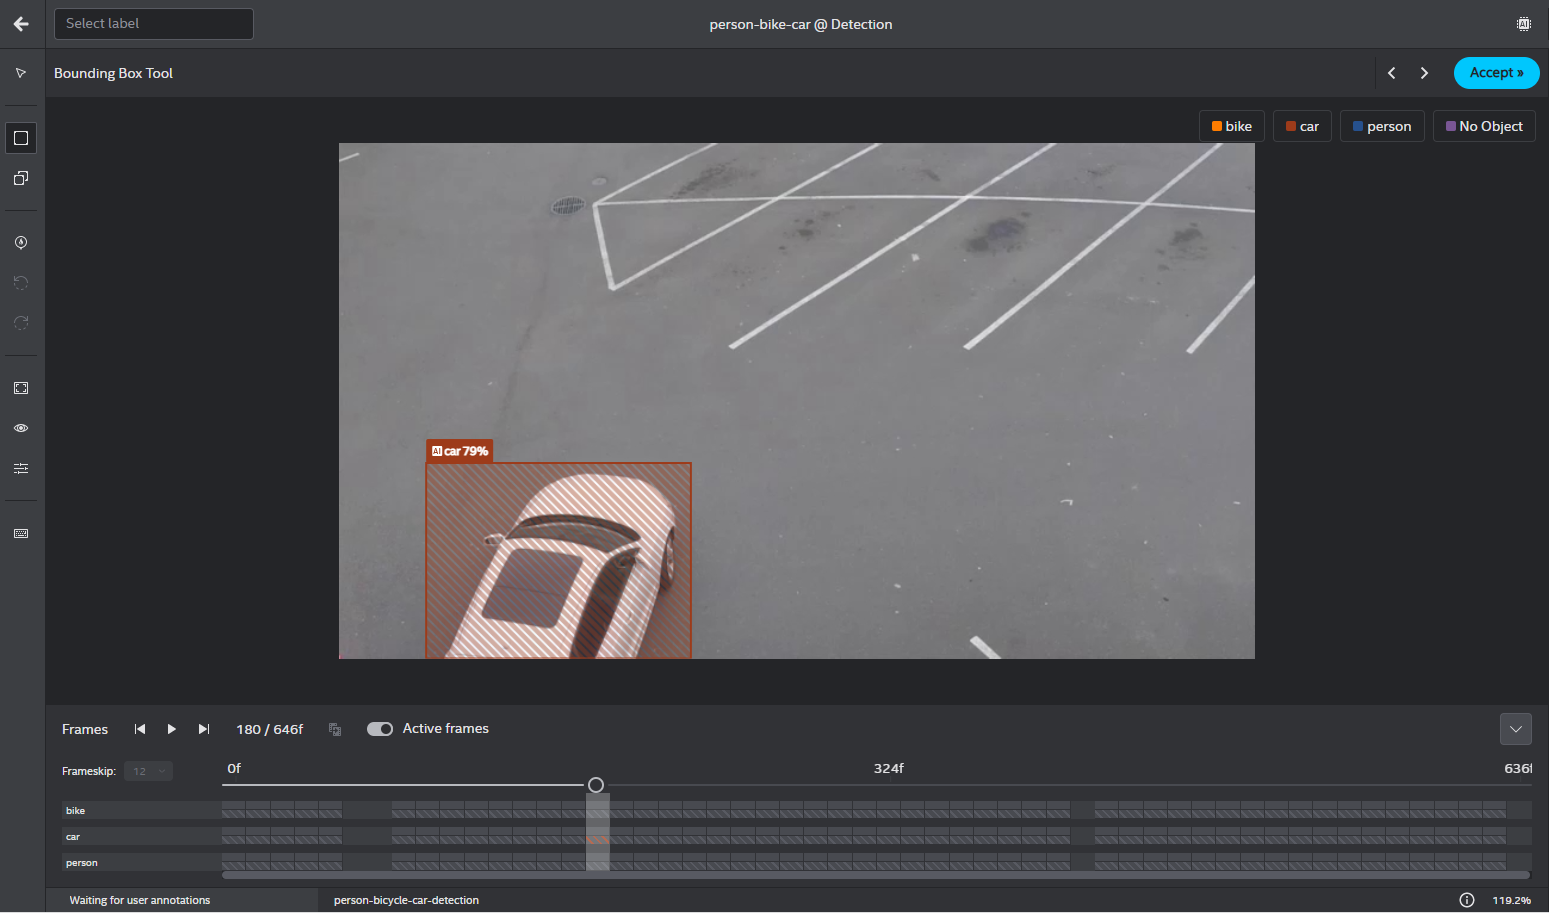 | 
|:--:| 
| *Interactive annotation with the Intel® Geti™ Platform* |

Alternatively, if you have used the default 'person_car_bike' video that we provided, you can run the cell below to upload some pre-defined annotations for the video to the project. This saves you some time in annotating the frames.

# Step 10: Running Offline Project

## Prepare Data

The following cell prepares data for the next steps:

In [ ]:
!rm -fr ./deployments && ln -sfn /data/reference-sample-data/geti-sdk/notebooks/use_cases/deployments ./deployments
!rm -fr ./data && ln -sfn /data/reference-sample-data/geti-sdk/notebooks/use_cases/data ./data

## Run Interactive Demo

The following cell declares a `run_object_detection` method to run the demo interactively:

In [ ]:
import os

import cv2
from IPython import display
from utils import VideoPlayer

from geti_sdk.deployment import Deployment
from geti_sdk.utils import show_image_with_annotation_scene
from geti_sdk.demos import get_person_car_bike_video

PROJECT_NAME = "person-bike-car"
PRECISION = "FP16"
PATH_TO_DEPLOYMENT_FOLDER = os.path.join("deployments", PROJECT_NAME, PRECISION)

# Get the path to the offline deployment
offline_deployment = Deployment.from_folder(PATH_TO_DEPLOYMENT_FOLDER)
offline_deployment.load_inference_models(device="CPU")

# Get the path to the example video. This will download the video if it is not found on your disk yet
VIDEO_PATH = get_person_car_bike_video(video_path="person-bicycle-car-detection.mp4")
video_file = VIDEO_PATH

# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, skip_first_frames=0):
    player = None
    try:
        # Create a video player to play with target fps
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )

        # Start capturing.
        player.start()

        while True:
            # Grab the frame.
            frame = player.next()
            
            # Stop if there are no more frames
            if frame is None:
                print("Source ended")
                break

            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )

            # Using offline predictions
            prediction = offline_deployment.infer(frame)

            # Creating output with bounding boxes, labels, and confidence
            output = show_image_with_annotation_scene(
                cv2.cvtColor(frame, cv2.COLOR_RGB2BGR), prediction, show_results=False
            )

            # Encode numpy array to jpg.
            _, encoded_img = cv2.imencode(
                ext=".jpg", img=output, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
            )

            # Create an IPython image.
            i = display.Image(data=encoded_img)

            # Display the image in this notebook.
            display.clear_output(wait=True)
            display.display(i)
    
    # Catch all errors
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()

The following cell runs the `run_object_detection` method to start the inference process in the local environment:

In [ ]:
run_object_detection(source=video_file, flip=False)

## Run Inference at the Edge

The following cell creates a `job.sh` file that we can submit to an Edge node:

In [ ]:
%%writefile job.sh

#!/bin/bash

# Positional input arguments: <OUTPUT_PATH> <DEVICE>
OUTPUT_PATH=$1
DEVICE=$2

# Debugging Information
echo VENV_PATH=$VENV_PATH
echo PBS_O_WORKDIR=$PBS_O_WORKDIR
echo PBS_JOBID=$PBS_JOBID
echo OUTPUT_PATH=$OUTPUT_PATH
echo DEVICE=$DEVICE

# Activate Virtual Environment
echo "Activating virtual environment ${VENV_PATH}"
source ${VENV_PATH}/bin/activate

# The default path for the job is the user's home directory,
# change directory to where the files are.
cd $PBS_O_WORKDIR

# Make sure that the output directory exists.
mkdir -p $OUTPUT_PATH

# Run the project
python3 job.py \
    -o $OUTPUT_PATH \
    -d $DEVICE

The following cell creates a `job.py` file that gets executed in the Edge node:

In [ ]:
%%writefile job.py

import collections
import time
import os
import json
import sys

import cv2
import applicationMetricWriter as amw
import numpy as np
from argparse import ArgumentParser
from utils import VideoPlayer

from geti_sdk.deployment import Deployment
from geti_sdk.utils import show_image_with_annotation_scene

PROJECT_NAME = "person-bike-car"
PRECISION = "FP16"
PATH_TO_DEPLOYMENT_FOLDER = os.path.join("deployments", PROJECT_NAME, PRECISION)

# Get the path to the offline deployment
offline_deployment = Deployment.from_folder(PATH_TO_DEPLOYMENT_FOLDER)

# Get the path to the example video.
VIDEO_PATH = os.path.join("data", "102_from_zero_to_hero", "person-bicycle-car-detection.mp4")
video_file = VIDEO_PATH


def build_argparser():
    """Input Arguments"""
    parser = ArgumentParser()
    parser.add_argument(
        "-d",
        "--device",
        help="Specify the target infer device to; CPU, GPU"
        "(CPU by default).",
        default="CPU",
        type=str,
    )
    parser.add_argument(
        "-o",
        "--output_path",
        help="Location to store the results of the processing",
        default="results",
        required=True,
        type=str,
    )
    return parser

# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, skip_first_frames=0, output_path="results"):
    player = None
    fps = 0
    processing_times = collections.deque()
    processing_fps = collections.deque()
    frames_counter = 0
    try:
        # ================1. Create a video player to play with target fps================
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )

        # Start capturing.
        player.start()
    
        while True:
            # Grab the frame.
            frame = player.next()
            frames_counter = frames_counter + 1
            
            # Stop if there are no more frames
            if frame is None:
                print("Source ended")
                break

            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )

            # Measure processing start time
            start_time = time.time()

            # Using offline predictions
            prediction = offline_deployment.infer(frame)
            
            # Measure processing stop time
            stop_time = time.time()
            
            # Save processing time
            processing_time = stop_time - start_time
            processing_times.append(processing_time)
            
            # Send application metrics
            amw.send_inference_time(processing_time * 1000)

            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            
            # Save the processing fps for your reference
            fps = 1000 / processing_time
            processing_fps.append(fps)

            # Use processing fps from last 200 frames.
            if len(processing_fps) > 200:
                processing_fps.popleft()

            # Report progress
            if frames_counter % 50 == 0:
                print(f"frame_counter={frames_counter}, processing_time={processing_time}, fps={fps}")

    # Catch all errors
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()

        if len(processing_times) > 0 and len(processing_fps) > 0:
            # Calculate metrics
            avg_processing_time = int(np.mean(processing_times) * 1000)
            avg_processing_fps = int(np.mean(processing_fps))
            
            # Data to be written
            results = {
                "time": f"{avg_processing_time}",
                "fps": f"{avg_processing_fps}",
                "frames": f"{frames_counter}"
            }
            
            # Serialized output
            json_object = json.dumps(results, indent=4)
            
            # Calculate output path
            stats_path = os.path.join(output_path, "stats.json")
            
            # Writing to sample.json
            with open(stats_path, "w") as outfile:
                outfile.write(json_object)

# Main function
def main():
    # Arguments parser
    args = build_argparser().parse_args()
    offline_deployment.load_inference_models(device=args.device)

    # Calculate output path
    job_id = str(os.environ["PBS_JOBID"]).split(".")[0]
    output_path = os.path.join(args.output_path, job_id)
    
    # Create output path
    os.makedirs(output_path, exist_ok=True)
    
    # Run process
    run_object_detection(source=video_file, flip=False, output_path=output_path)
    
    # Send application metrics
    model_xml = os.path.join(PATH_TO_DEPLOYMENT_FOLDER, "deployment", "Detection task", "model", "model.xml")
    amw.send_application_metrics(model_xml, args.device)

if __name__ == "__main__":
    sys.exit(main() or 1)

The following cell creates an interactive interface to run jobs in Edge nodes:

In [ ]:
import json

from qarpo import Interface

# Load job configurations for demo
with open("./job_config.json") as json_file:
    data = json.load(json_file)

# Create and run the user job interface
job_interface = Interface(data)
job_interface.displayUI()

The following cell show the current state of submitted jobs in Edge nodes:

In [ ]:
from qarpo import liveQstat

# Watch the Edge node jobs
liveQstat()